### 异策略蒙特卡洛控制

In [1]:
%matplotlib inline
import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict 
from envs.blackjack import BlackjackEnv
from envs.plotting import plot_value_function

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
# 生成随机策略，输入行动空间大小，输出policy函数
# policy函数的输入是状态，输出所有可能行动的概率
def random_policy(nA):
    A = np.ones(nA, dtype=float) / nA
    def policy(state):
        return A
    return policy

In [4]:
# 生成贪婪策略，输入Q={state: action},输出policy函数
# policy函数的输入是状态，输出所有可能行动的概率
def greedy_policy(Q):
    def policy(state): 
        A_prob = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A_prob[best_action] = 1.0
        return A_prob
    return policy

In [5]:
# 基于自归一化重要性采样的异策略蒙特卡罗控制
def off_policy_mc_control(env, num_epi, behavior_policy, discount = 1.0):
    # Q = {state1:[action1-value, action2-value],state2:[action1-value, action2-value],...}
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # C:权重W的累加值
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    # 通过修改Q来寻找最优目标策略pi
    pi = greedy_policy(Q)
    
    for i in range(num_epi):
        epi = []
        state = env.reset()
        while(True):
            prob = behavior_policy(state)
            action = np.random.choice(np.arange(len(prob)), p=prob)
            next_state, reward, done, _ = env.step(action)
            epi = epi + [(state, action, reward)]
            if done:
                break
            state = next_state
        
        # 回报G，重要性权重W
        G = 0.0 
        W = 1.0
        # 从后往前遍历当前Episode，[::-1]实现倒序
        for t in range(len(epi))[::-1]:
            state, action, reward = epi[t]
            G = reward + discount * G
            C[state][action] += W
            # 增量更新Q，间接更新了目标策略pi
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            # 如果行为策略选择的行动不是目标策略的行动
            # 意味着pi(s|a)=0，对应的W=0，Q不变，可退出当前for循环
            if action != np.argmax(pi(state)):
                break
            W = W * 1.0 / behavior_policy(state)[action]
            
    return Q, pi      

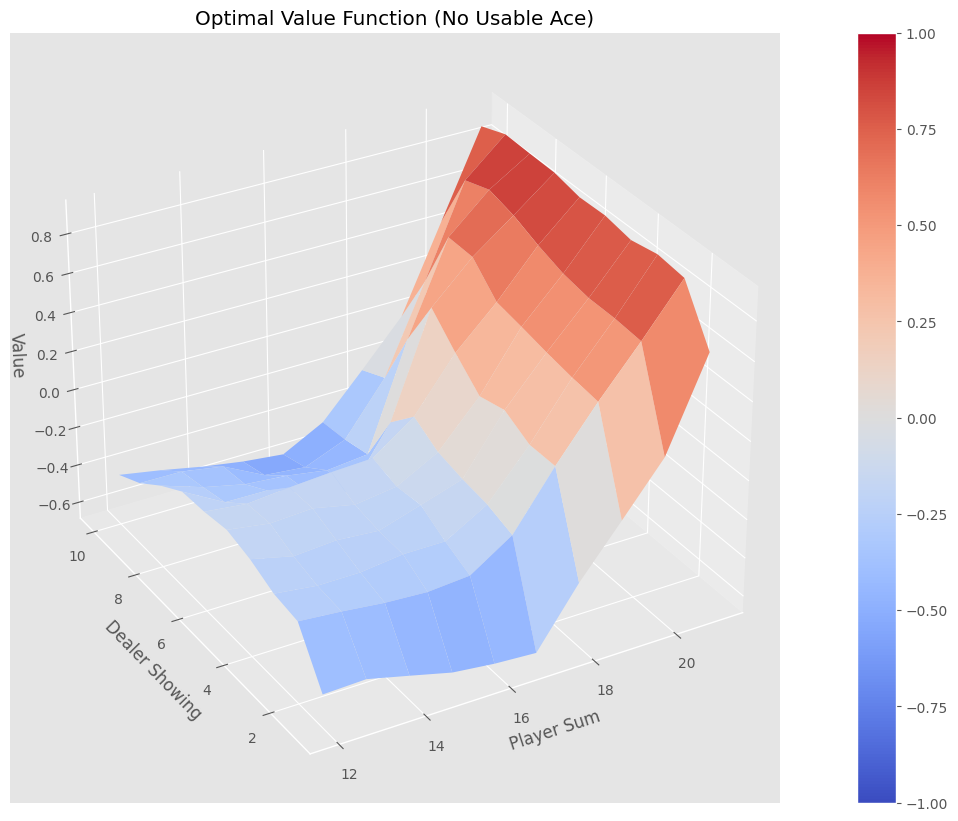

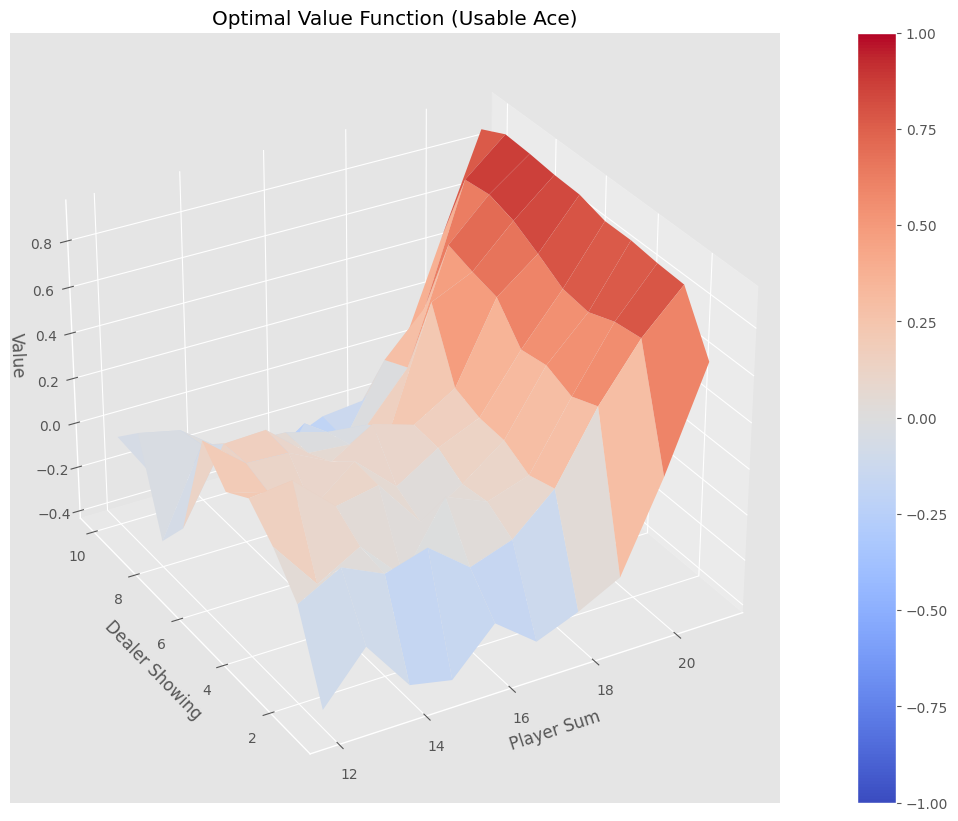

In [6]:
if __name__ == "__main__":
    b = random_policy(env.action_space.n)
    Q, pi = off_policy_mc_control(env, num_epi=500000, behavior_policy=b, discount = 1.0)
    V = defaultdict(float)
    for state, action_values in Q.items():
        action_value = np.max(action_values)
        V[state] = action_value
    plot_value_function(V, title="Optimal Value Function")